# Getting Embeddings

In [45]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 111]
[nltk_data]     Connection refused>


False

In [1]:
from transformers import BertModel, BertTokenizer,BertForPreTraining, BertConfig
from tqdm.auto import tqdm
import torch
import nltk
from pathlib import Path
import re
from scipy.spatial.distance import  cosine
import pickle
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
DATA_DIR = Path('data')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
SEEDS = ['finance', 'medicine', 'sports', 'technology']
NUM_WORDS_PER_SET = 10

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")


def get_embeddings(model, tokens, embedding_size=768):
    with torch.no_grad():
        output = model(**tokens)
        embedding = output.last_hidden_state[0][1]
        return torch.reshape(embedding, (embedding_size, ))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
res = tokenizer("feline", return_tensors='pt')
vocab = list(tokenizer.get_vocab().keys())
for id in res['input_ids'][0]:
    print(f"{id} -> {vocab[id]}")


101 -> [CLS]
10768 -> fe
4179 -> ##line
102 -> [SEP]


In [15]:
model.eval()
def cos_sim(word1 , word2):
    word1_tokens = tokenizer(word1, return_tensors='pt')
    word2_tokens = tokenizer(word2, return_tensors='pt')
    word1_pred = model(**word1_tokens)
    word2_pred = model(**word2_tokens)
    word1_emb = word1_pred.last_hidden_state[:, 1, :].detach()
    word2_emb = word2_pred.last_hidden_state[:, 1, :].detach()
    return 1 - cosine(word1_emb, word2_emb)
print(f"Cosine similarity feline & cat", cos_sim("feline", "cat"))
print(f"Cosine similarity cat & cat", cos_sim("cat", "cat"))

Cosine similarity feline & cat 0.25982895493507385
Cosine similarity cat & cat 1


In [2]:
def get_embeddings_batch(model, tokens, embedding_size=768, batch_size=4):
    with torch.no_grad():
        output = model(**tokens)
        embedding = output.last_hidden_state[:, 1, :]
        return embedding


def cos_distance_batch(topic, words):
    return np.inner(
        topic, words) / (np.linalg.norm(topic) * np.linalg.norm(words, axis=1))


def job(vocab, topic, tokenizer, model, batch_size=4):
    res_col = np.zeros((len(vocab), ))
    vocab = list(vocab)
    loop = tqdm(range(0, len(vocab), batch_size))
    loop.set_description(f"topic: {topic}")
    topic_token = tokenizer(topic,
                            return_tensors='pt',
                            padding=True,
                            max_length=10,
                            truncation=True)
    topic_emb = get_embeddings(model, topic_token)
    for batch_index in loop:
        lo = batch_index
        hi = min(batch_index + batch_size, len(vocab))
        batch = vocab[batch_index:batch_index + batch_size]
        tokens = tokenizer(batch,
                           return_tensors='pt',
                           padding='max_length',
                           max_length=10,
                           truncation=True)
        # if len(token['input_ids']) > 3:
        #     print(f"WARNING: Word '{word}' is not in BERT's vocabulary")
        word_embs = get_embeddings_batch(model, tokens)
        res_col[lo:hi] = cos_distance_batch(topic_emb, word_embs)
        # res_col.append(cosine(topic_emb, word_emb))
    return res_col

In [12]:
tokens = tokenizer(" Neurological")
tokenizer.add_tokens
for token in tokens['input_ids']:
    print(tokenizer.decode(token))

[ C L S ]
n e u r o l o g i c a l
[ S E P ]


In [ ]:
tokenizer('[MASK]')

In [ ]:
cat_emb = get_embeddings(cat_outputs)
hello_emb = get_embeddings(hello_outputs)
hi_emb = get_embeddings(hi_outputs)

print(cosine(hi_emb, hello_emb))
print(cosine(hi_emb, cat_emb))

In [ ]:
cosine([1], [0.1])

# Building vocab for the corpus

In [ ]:
df = pd.read_csv(Path('data') / 'content_cleaned.txt')
df.head()

In [ ]:

stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
def vocab_preprocess(row, lemmatize=True):
    from nltk.stem import WordNetLemmatizer
    row = row.lower().strip()
    words = row.split(' ')
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    res = {}
    for word in words:
        count = res.get(word, 0)
        count += 1
        res[word] = count
    if (lemmatize):
        words = [lemmatizer.lemmatize(word) for word in words]

    return res

In [ ]:
MIN_COUNT=3
f = open('data/content_cleaned.txt')
lines = f.readlines()
f.close()
data = []
vocab = {}
for i, row in tqdm(enumerate(lines)):
    freq = vocab_preprocess(row, False)
    for _word, _count in freq.items():
        count = vocab.get(_word, 0) + _count
        vocab[_word] = count
uncommon_words = []
for word, count in tqdm(vocab.items()):
    if count < MIN_COUNT:
       uncommon_words.append(word)
print(len(uncommon_words))
print(len(vocab.keys()))
for word in uncommon_words:
    del vocab[word]
print(len(vocab.keys()))
with open(DATA_DIR / "vocab" / "global_vocab_no_lemmatize.pkl", "wb") as f:
    pickle.dump(vocab, f)

# Build global rankings

In [ ]:
vocab = None
with open(DATA_DIR / "vocab" / "global_vocab_no_lemmatize.pkl", "rb") as f:
    vocab = pickle.load(f)
print(len(vocab))

In [ ]:

topic_embeddings = []
cols = []
for seed in SEEDS:
    cols.append(job(vocab, seed, tokenizer, model, batch_size=128))


In [ ]:
arr = np.array(cols)
res_dict = {
    '_vocab': list(vocab),
}
for i, topic in enumerate(SEEDS):
    print(arr[i].shape)
    res_dict[topic] = arr[i]
res_df = pd.DataFrame(res_dict)
res_df = res_df.set_index(['_vocab'])
res_df.to_csv('./results/global_cos_similarity.csv')
res_df.sort_values('finance', ascending=False).head(10)

In [6]:
import pandas as pd
df = pd.read_csv('./results/global_cos_similarities.csv', index_col='_vocab')
df.head(5)

,finance,medicine,sports,technology
_vocab,,,,
wall,0.517498,0.460783,0.379825,0.507667
dwindling,0.266420,0.276414,0.229889,0.300718
band,0.526177,0.547440,0.491915,0.555572
seeing,0.470583,0.458130,0.322104,0.511387
green,0.475073,0.447803,0.477264,0.544758


In [ ]:
res_df.sort_values(by='technology', ascending=False).head(10)

# Initialize word sets from $e$

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
res_df = pd.read_csv('global_cos_similarity.csv')
res_df = res_df.set_index(['_vocab'])
word_set = {}
added_words = set()
for seed in SEEDS:
    word_set[seed] = []
    col = res_df[seed]
    sorted_col = col.sort_values()[::-1]
    i = 0
    for word, _ in sorted_col.iteritems():
        if i == NUM_WORDS_PER_SET + 1:
            break
        if word not in added_words:
            word_set[seed].append(word)
            added_words.add(word)
            i += 1

word_set_df = pd.DataFrame(word_set)
word_set_df.head()

In [ ]:
for topic, words in word_set.items():
    print(f"{' '.join(words[1:4])}")

# Local Knowlege using pretrained BERT

In [ ]:
# Prepare datasets
from transformers import BertTokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset, concatenate_datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)
dataset = load_dataset('ag_news')

In [ ]:
concatenate_datasets([dataset['train'], dataset['test']], axis=0)

In [ ]:
%%bash

python3 scripts/train.py \
    -o ./models \
    -t ./data/tokens/tokens-pretrained-30522.pkl \
    -n bert-pretrined-30522 

# Compute Local Cosine similarity

In [ ]:
model = BertModel.from_pretrained('models/bert-pretrained-pretrained-30522-2022-06-22-10-34/checkpoint-10000')
model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
with open('data/vocab/global_vocab_no_lemmatize.pkl', 'rb') as f:
    vocab = pickle.load(f)
len(vocab)

In [ ]:
def get_embeddings_batch(model, tokens, embedding_size=768, batch_size=4):
    with torch.no_grad():
        output = model(**tokens)
        embedding = output.last_hidden_state[:, 1, :]
        return embedding


def cos_distance_batch(topic, words):
    return np.inner(topic, words) / (np.linalg.norm(topic) * np.linalg.norm(words, axis=1))


def job(vocab, topic, tokenizer, model, batch_size=4):
    res_col = np.zeros((len(vocab), ))
    vocab = list(vocab)
    loop = tqdm(range(0, len(vocab), batch_size))
    loop.set_description(f"topic: {topic}")
    topic_token = tokenizer(topic, return_tensors='pt', padding=True, max_length=10, truncation=True)
    topic_emb = get_embeddings(model, topic_token)
    for batch_index in loop:
        lo = batch_index
        hi = min(batch_index + batch_size, len(vocab))
        batch = vocab[batch_index:batch_index + batch_size]
        tokens = tokenizer(batch, return_tensors='pt', padding='max_length', max_length=10, truncation=True)
        # if len(token['input_ids']) > 3:
        #     print(f"WARNING: Word '{word}' is not in BERT's vocabulary")
        word_embs = get_embeddings_batch(model, tokens)
        res_col[lo:hi] = cos_distance_batch(topic_emb, word_embs)
        # res_col.append(cosine(topic_emb, word_emb))
    return res_col

In [ ]:
res = []
for topic in SEEDS:
    res_col = job(vocab, topic, tokenizer, model, batch_size=256)
    res.append(res_col)

In [ ]:

arr = np.array(res)
arr = arr.T
res_dict = {    
    '_vocab': list(vocab),
}
for i, topic in enumerate(SEEDS):
    res_dict[topic] = arr[:, i]
res_df = pd.DataFrame(res_dict)
res_df = res_df.set_index(['_vocab'])
res_df.to_csv('local_embeddings_bert-pretrained-pretrained.csv')

In [ ]:
res_df = pd.read_csv('./local_embeddings_bert-pretrained-pretrained.csv', index_col='_vocab')
res_df.sort_values('finance', ascending=False).head(10)

In [ ]:
# BERTopic

In [ ]:
from bertopic import BERTopic

seeds = np.array([SEEDS]).T.tolist()
topic_model = BERTopic(seed_topic_list=seeds)
docs = pd.read_csv(DATA_DIR / 'dataset.csv')['description']
topic_model.fit_transform(docs)

In [ ]:
similar_topics, similarity = topic_model.find_topics("finance", top_n=5)
for i, topic in enumerate(similar_topics):
    print(topic_model.get_topic(topic)[0][0], similarity[i])

# CatE
**kwown issue**: Seg Fault when seed words > 3

In [ ]:
import pandas as pd

local_emb_vocab_df = pd.read_csv(
    'results/CatE/2022-07-07-12-43/emb_seeds_w.txt',
    sep=' ',
    skiprows=[0],
    index_col=0,
    header=None)
local_emb_vocab_df.dropna(axis=1, inplace=True)

local_emb_topic_df = pd.read_csv(
    'results/CatE/2022-07-07-12-43/emb_seeds_t.txt',
    sep=' ',
    skiprows=[0],
    index_col=0,
    header=None)
local_emb_topic_df.dropna(axis=1, inplace=True)


In [ ]:
def compute_cate_cos_similarity(vocab, vocab_embs, topic_emb, topic, batch_size=32, show_progress=True):
    res_col = np.zeros((len(vocab), ))
    loop = range(0, len(vocab), batch_size)
    if show_progress:
        loop = tqdm(loop)
        loop.set_description(f"topic: {topic}")
    for batch_index in loop:
        lo = batch_index
        hi = min(batch_index + batch_size, len(vocab))

        batch = vocab[lo:hi]
        batch_embs = vocab_embs.loc[batch, :]
        res_col[lo:hi] = cos_distance_batch(topic_emb, batch_embs)
        # res_col.append(cosine(topic_emb, word_emb))
    return res_col

In [ ]:
vocab_f = open('./data/vocab/global_vocab_no_lemmatize.pkl', 'rb')
vocab = pickle.load(vocab_f)
vocab_f.close()
not_in_vocab_words = []
for word in vocab.keys():
    if word not in local_emb_vocab_df.index:
        not_in_vocab_words.append(word)
print(len(not_in_vocab_words))
for word in not_in_vocab_words:
    del vocab[word]
for word in local_emb_vocab_df.index:
    if word not in vocab:
        local_emb_vocab_df =  local_emb_vocab_df.drop(word, axis=0)

In [ ]:
res = {}
res['_vocab'] = vocab.keys()
for topic in local_emb_topic_df.index:
    topic_emb = local_emb_topic_df.loc[topic, :]
    res_col = compute_cate_cos_similarity(list(vocab.keys()), local_emb_vocab_df, topic_emb, topic, show_progress=False)
    res[topic] = res_col


In [ ]:
res_df = pd.DataFrame(res)
res_df = res_df.set_index(['_vocab'])
res_df.to_csv('./results/CatE/2022-07-07-12-43/cate_local_embeddings.csv')

# Compute Ensemble ranking [Proposed]
Which does not work as expected -> CatE has different embeddings for the same word in topic and vocab

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
local_emb_vocab_df = pd.read_csv(
    'results/CatE/2022-07-07-12-43/emb_seeds_w.txt',
    sep=' ',
    skiprows=[0],
    index_col=0,
    header=None)
local_emb_vocab_df.dropna(axis=1, inplace=True)

local_emb_topic_df = pd.read_csv(
    'results/CatE/2022-07-07-12-43/emb_seeds_t.txt',
    sep=' ',
    skiprows=[0],
    index_col=0,
    header=None)
local_emb_topic_df.dropna(axis=1, inplace=True)

In [ ]:
def compute_vocab_cos_similarity(emb):
    out_shape = (emb.shape[0], emb.shape[0])
    df = pd.DataFrame(np.zeros((out_shape)), index=emb.index, columns=emb.index)
    for word in tqdm(emb.index):
        topic_emb = emb.loc[word, :]
        res_row = cos_distance_batch(topic_emb, emb)
        df.loc[word, :] = res_row
    return df
res = compute_vocab_cos_similarity(local_emb_vocab_df)
res.to_csv('results/CatE/2022-07-07-12-43/cate_cos_similarities.csv')

In [ ]:
res.loc['accounting', 'unumprovident']

In [ ]:
cosine(local_emb_vocab_df.loc['accounting', :], local_emb_topic_df.loc['accounting', :])

# Compute emsemble ranking [CatE]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
global_cos_df = pd.read_csv('./results/global_cos_similarity.csv', index_col=0)
local_cos_df = pd.read_csv('./results/cate_local_embeddings.csv', index_col=0)
# min_max_scalar


In [ ]:
def ensemble_ranking(score_g, score_l, rho):
    exponent = 1 / rho
    base = 0.5 * np.power(1/score_g, rho) + 0.5 * np.power(1/score_l, rho) 
    return 1/np.power(base, exponent)

def scale_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

def compute_vocab_ensemble_rankings(score_l_df, score_g_df, vocab, rho=1): 
    raw = np.zeros((len(vocab), score_l_df.shape[1])).astype(np.double)
    res = pd.DataFrame(raw, index=vocab, columns=score_g_df.columns)
    for topic_idx in range(score_l_df.shape[1]):
        score_l = score_l_df.loc[vocab, score_l_df.columns[topic_idx]]
        score_g = score_g_df.loc[vocab, score_g_df.columns[topic_idx]]
        res.iloc[:, topic_idx] = ensemble_ranking(score_l, score_g, rho)
    return res
s_global_cos_df = scale_data(global_cos_df)
local_cos_df.loc[:, :] = scale_data(local_cos_df)
global_cos_df.loc[:, :] = scale_data(global_cos_df)
res = compute_vocab_ensemble_rankings(local_cos_df, global_cos_df, local_cos_df.index)
res['finance'].sort_values(ascending=False)
res.to_csv('./results/ensemble/cate_ensemble_rankings.csv') 

# Compute emsemble ranking [BERT-pretrained]

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
global_cos_df = pd.read_csv('./results/global_cos_similarities.csv', index_col=0)
local_cos_df = pd.read_csv('./results/bert/bert-pretrained.csv', index_col=0)

In [ ]:
def ensemble_ranking(score_g, score_l, rho):
    exponent = 1 / rho
    base = 0.4 * np.power(1/score_g, rho) + 0.6 * np.power(1/score_l, rho) 
    return 1/np.power(base, exponent)

def compute_vocab_ensemble_rankings(score_l_df, score_g_df, vocab, rho=0.5): 
    raw = np.zeros((len(vocab), score_l_df.shape[1])).astype(np.double)
    res = pd.DataFrame(raw, index=vocab, columns=score_g_df.columns)
    for topic_idx in range(score_l_df.shape[1]):
        score_l = score_l_df.loc[vocab, score_l_df.columns[topic_idx]]
        score_g = score_g_df.loc[vocab, score_g_df.columns[topic_idx]]
        res.iloc[:, topic_idx] = ensemble_ranking(score_l, score_g, rho)
    return res
res = compute_vocab_ensemble_rankings(global_cos_df, local_cos_df, local_cos_df.index)
res['finance'].sort_values(ascending=False)


In [1]:
import pandas as pd
df = pd.read_csv('./results/ensemble/local-0.5-global-0.5-rho-0.5/ensemble_score_bert-pretrained.csv')
df.head()

,_vocab,finance,medicine,sports,technology
0,wall,0.480366,0.441591,0.379867,0.536030
1,dwindling,0.229864,0.266148,0.218962,0.258488
2,band,0.510579,0.504599,0.500365,0.569179
3,seeing,0.368104,0.402800,0.310974,0.414164
4,green,0.392359,0.428595,0.392232,0.421796


# Build occurance matrix

In [ ]:
import pickle
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
with open('./data/vocab/global_vocab_no_lemmatize.pkl', 'rb') as f:
    vocab = pickle.load(f)
data = np.zeros((len(vocab), len(vocab)))
cooccur = pd.DataFrame(columns=vocab.keys(), index=vocab.keys(), data=data)
with open('./data/content_cleaned.txt') as f:
    lines =  f.readlines()
    for line in tqdm(lines):
        words = [word for word in line.split(' ') if word in vocab.keys()]
        for word_x in words: 
            for word_y in words:
                if word_x != word_y:
                    cooccur.loc[word_x, word_y] += 1



In [ ]:
import json
import nltk


with open('./results/pmis/run-2022-07-06-10-22/local-0.7-global-0.3-rho-0.5.json', 'r') as f:
    res = json.load(f)
word_set = res['ensemble_score_bert-local-scratch-25000']['word_set']
compute_distinctiveness(word_set)

In [ ]:
cooccur['finance', 'banking']

In [ ]:
cooccur.loc['finance','finance']
cooccur.to_csv('./data/vocab/cooccurence_matrix_quick.csv')

In [ ]:
cooccur_new.loc['finance', 'finance']
cooccur_new.to_csv('./data/vocab/cooccurence_matrix.csv')

# Build PMI

In [ ]:
import numpy as np
import pandas as pd
cooccur_mat = pd.read_csv('./data/vocab/cooccurence_matrix-agnews.csv', index_col=0)


In [ ]:
scores_df = pd.read_csv(
    "results/ensemble/ensemble_score_bert-pretrained_2022-07-03-13-12.csv", index_col='_vocab')
SEEDS = ['finance', 'sports', 'medicine', 'technology']
res = {}
for topic in SEEDS:
    res[topic] = list(scores_df[topic].sort_values(ascending=False).head(5).index)
res

In [ ]:
def prob_word(word, mat):
    return np.sum(mat[word]) / np.sum(mat.to_numpy())
def prob_cooccur(a, b, mat):
    return mat.loc[a, b] / np.sum(mat.to_numpy())
def pmi(a, b, mat):
    prob_a=prob_word(a, mat)
    prob_b=prob_word(b, mat)
    prob_ab_cooccur = prob_cooccur(a,b, mat)
    return prob_ab_cooccur / (prob_a * prob_b)
pmis = {}

In [ ]:
pmis = {}
for topic in SEEDS:
    pmis[topic] = np.sum([pmi(word, topic, cooccur_mat) for word in res[topic]])
pmis

In [ ]:
cooccur_mat.loc['medicine', 'pathology']

In [ ]:
import pandas as pd

local_emb_vocab_df = pd.read_csv('./results/CatE/emb_seeds_w.txt', sep=' ', skiprows=[0], index_col=0, header=None)
local_emb_vocab_df.dropna(axis=1, inplace=True)

local_emb_topic_df = pd.read_csv('./results/CatE/emb_seeds_t.txt', sep=' ', skiprows=[0], index_col=0, header=None)
local_emb_topic_df.dropna(axis=1, inplace=True)

In [ ]:
def compute_vocab_cos_similarity(emb):
    out_shape = (emb.shape[0], emb.shape[0])
    df = pd.DataFrame(np.zeros((out_shape)), index=emb.index, columns=emb.index)
    for word in tqdm(emb.index):
        topic_emb = emb.loc[word, :]
        res_row = cos_distance_batch(topic_emb, emb)
        df.loc[word, :] = res_row
    return df
res = compute_vocab_cos_similarity(local_emb_vocab_df)

In [ ]:
res.loc['accounting', 'unumprovident']

In [ ]:
cosine(local_emb_vocab_df.loc['accounting', :], local_emb_topic_df.loc['accounting', :])

# Compute emsemble ranking [CatE]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
global_cos_df = pd.read_csv('./results/global_cos_similarity.csv', index_col=0)
local_cos_df = pd.read_csv('./results/cate_local_embeddings.csv', index_col=0)
# min_max_scalar


In [ ]:
def ensemble_ranking(score_g, score_l, rho):
    exponent = 1 / rho
    base = 0.5 * np.power(1/score_g, rho) + 0.5 * np.power(1/score_l, rho) 
    return 1/np.power(base, exponent)

def scale_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

def compute_vocab_ensemble_rankings(score_l_df, score_g_df, vocab, rho=1): 
    raw = np.zeros((len(vocab), score_l_df.shape[1])).astype(np.double)
    res = pd.DataFrame(raw, index=vocab, columns=score_g_df.columns)
    for topic_idx in range(score_l_df.shape[1]):
        score_l = score_l_df.loc[vocab, score_l_df.columns[topic_idx]]
        score_g = score_g_df.loc[vocab, score_g_df.columns[topic_idx]]
        res.iloc[:, topic_idx] = ensemble_ranking(score_l, score_g, rho)
    return res
s_global_cos_df = scale_data(global_cos_df)
local_cos_df.loc[:, :] = scale_data(local_cos_df)
global_cos_df.loc[:, :] = scale_data(global_cos_df)
res = compute_vocab_ensemble_rankings(local_cos_df, global_cos_df, local_cos_df.index)
res['finance'].sort_values(ascending=False)
res.to_csv('./results/ensemble/cate_ensemble_rankings.csv') 

# Compute emsemble ranking [BERT-pretrained]

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
global_cos_df = pd.read_csv('./results/global_cos_similarities.csv', index_col=0)
local_cos_df = pd.read_csv('./results/bert/bert-pretrained.csv', index_col=0)

In [ ]:
def ensemble_ranking(score_g, score_l, rho):
    exponent = 1 / rho
    base = 0.4 * np.power(1/score_g, rho) + 0.6 * np.power(1/score_l, rho) 
    return 1/np.power(base, exponent)

def compute_vocab_ensemble_rankings(score_l_df, score_g_df, vocab, rho=0.5): 
    raw = np.zeros((len(vocab), score_l_df.shape[1])).astype(np.double)
    res = pd.DataFrame(raw, index=vocab, columns=score_g_df.columns)
    for topic_idx in range(score_l_df.shape[1]):
        score_l = score_l_df.loc[vocab, score_l_df.columns[topic_idx]]
        score_g = score_g_df.loc[vocab, score_g_df.columns[topic_idx]]
        res.iloc[:, topic_idx] = ensemble_ranking(score_l, score_g, rho)
    return res
res = compute_vocab_ensemble_rankings(global_cos_df, local_cos_df, local_cos_df.index)
res['finance'].sort_values(ascending=False)


# Build occurance matrix

In [ ]:
import pickle
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
with open('./data/vocab/global_vocab_no_lemmatize.pkl', 'rb') as f:
    vocab = pickle.load(f)
data = np.zeros((len(vocab), len(vocab)))
cooccur = pd.DataFrame(columns=vocab.keys(), index=vocab.keys(), data=data)
with open('./data/content_cleaned.txt') as f:
    lines =  f.readlines()
    for line in tqdm(lines):
        words = [word for word in line.split(' ') if word in vocab.keys()]
        for word_x in words: 
            for word_y in words:
                if word_x != word_y:
                    cooccur.loc[word_x, word_y] += 1



In [ ]:
cooccur['finance', 'banking']

In [ ]:
cooccur.loc['finance','finance']
cooccur.to_csv('./data/vocab/cooccurence_matrix_quick.csv')

In [ ]:
cooccur_new.loc['finance', 'finance']
cooccur_new.to_csv('./data/vocab/cooccurence_matrix.csv')

# Build PMI

In [ ]:
cooccur_mat.loc['medicine', 'pathology']

In [4]:
from pathlib import Path
from scripts.evaluation import evaluation
import pandas as pd

PROJECT_ROOT = Path(
    ".").absolute()
CONFIG = {
    # local_weight, global_weight, rho
    "specs": [
        # changes in weights
        (0.3, 0.7, 0.5),
        (0.4, 0.6, 0.5),
        (0.5, 0.5, 0.5),
        (0.6, 0.4, 0.5),
        (0.7, 0.3, 0.5),
        # changes in rho
        (0.5, 0.5, 0.1),
        (0.5, 0.5, 0.3),
        (0.5, 0.5, 0.7),
        (0.5, 0.5, 0.9),
    ],
    "inputs": [
        *(PROJECT_ROOT / 'results' / 'bert').glob("*"),
        (PROJECT_ROOT / 'results' / 'CatE' / '2022-07-03-09-36' /
         'cate-cos-similarities.csv')
    ],
    "baselines": [
        PROJECT_ROOT / 'results' / 'global_cos_similarities.csv',
        PROJECT_ROOT / 'results' / 'cate_cos_similarities.csv'
    ],
    "global_score":
    PROJECT_ROOT / 'results' / 'global_cos_similarities.csv',
    "n_words":
    10
}
cooccur_mat = pd.read_csv(PROJECT_ROOT / 'data' / 'vocab' /
                          'cooccurence_matrix-agnews.csv',
                          index_col=0)
evaluation([str(p) for p in CONFIG['baselines']],
           cooccur_mat,
           out=PROJECT_ROOT / 'results' / 'evaluations' / 'baselines.json')


KeyboardInterrupt: 

# Create Plots

In [2]:
import json
from matplotlib import pyplot as plt
from pathlib import Path
import json
COMPARE_GROUPS = [[(0.1, 0.9, 0.5), (0.2, 0.8, 0.5), (0.3, 0.7, 0.5),
                   (0.4, 0.6, 0.5), (0.5, 0.5, 0.5), (0.6, 0.4, 0.5),
                   (0.7, 0.3, 0.5), (0.8, 0.2, 0.5), (0.9, 0.1, 0.5),],
                  [
                      (0.5, 0.5, 0.1),
                      (0.5, 0.5, 0.3),
                      (0.5, 0.5, 0.5),
                      (0.5, 0.5, 0.7),
                      (0.5, 0.5, 0.9),
                  ]]
def load_results(results_dir: Path, baseline_path: Path):
    if not results_dir.exists():
        raise FileNotFoundError(f"{results_dir} does not exist")
    files = results_dir.glob("*.json")
    results = {}
    baseline_results = {}
    for file_path in files:
        data = None
        with open(file_path, 'r') as f:
            data = json.load(f)
        basename = file_path.name[:-5]
        results[basename] = data
    with open(baseline_path, 'r') as f:
        data = json.load(f)
        for key, val in data.items():
            baseline_results[key] = val
    return results, baseline_results

def parse_results(compare_groups, results):
    pmis = []
    npmis = []
    dists = []
    sem_dists = []
    for group in compare_groups:
        grp_pmis = {
            'ensemble_score_bert-pretrained': [],
            'ensemble_score_bert-local-scratch-30522': [],
            'ensemble_score_bert-local-scratch-25000': [],
            'ensemble_score_cate-cos-similarities': []
        }
        grp_npmis = {
            'ensemble_score_bert-pretrained': [],
            'ensemble_score_bert-local-scratch-30522': [],
            'ensemble_score_bert-local-scratch-25000': [],
            'ensemble_score_cate-cos-similarities': []
        }
        grp_dists = {
            'ensemble_score_bert-pretrained': [],
            'ensemble_score_bert-local-scratch-30522': [],
            'ensemble_score_bert-local-scratch-25000': [],
            'ensemble_score_cate-cos-similarities': []
        }
        grp_sem_dists = {
            'ensemble_score_bert-pretrained': [],
            'ensemble_score_bert-local-scratch-30522': [],
            'ensemble_score_bert-local-scratch-25000': [],
            'ensemble_score_cate-cos-similarities': []
        }
        for spec in group:
            print(spec)
            local_w, global_w, rho = spec
            i = f"local-{local_w}-global-{global_w}-rho-{rho}"
            for key, val in results[i].items():
                grp_pmis[key].append(val['pmi'])
                grp_npmis[key].append(val['npmi'])
                grp_dists[key].append(val['distinctiveness'])
                grp_sem_dists[key].append(val['sem_distinctiveness'])

        pmis.append(grp_pmis)
        npmis.append(grp_npmis)
        dists.append(grp_dists)
        sem_dists.append(grp_sem_dists)
    return pmis, npmis, dists, sem_dists
results_in_vocab, base_results = load_results(Path('./results/evaluations/cate_in_vocab/'), './results/evaluations/baselines.json')
results, base_results = load_results(Path('./results/evaluations/run-2022-07-12-09-52/'), './results/evaluations/baselines.json')

pmis_in_vocab, npmis_in_vocab, dists_in_vocab, sem_dists_in_vocab = parse_results(COMPARE_GROUPS, results_in_vocab)
pmis, npmis, dists, sem_dists = parse_results(COMPARE_GROUPS, results)
base_results

(0.1, 0.9, 0.5)
(0.2, 0.8, 0.5)
(0.3, 0.7, 0.5)
(0.4, 0.6, 0.5)
(0.5, 0.5, 0.5)
(0.6, 0.4, 0.5)
(0.7, 0.3, 0.5)
(0.8, 0.2, 0.5)
(0.9, 0.1, 0.5)
(0.5, 0.5, 0.1)
(0.5, 0.5, 0.3)
(0.5, 0.5, 0.5)
(0.5, 0.5, 0.7)
(0.5, 0.5, 0.9)
(0.1, 0.9, 0.5)
(0.2, 0.8, 0.5)
(0.3, 0.7, 0.5)
(0.4, 0.6, 0.5)
(0.5, 0.5, 0.5)
(0.6, 0.4, 0.5)
(0.7, 0.3, 0.5)
(0.8, 0.2, 0.5)
(0.9, 0.1, 0.5)
(0.5, 0.5, 0.1)
(0.5, 0.5, 0.3)
(0.5, 0.5, 0.5)
(0.5, 0.5, 0.7)
(0.5, 0.5, 0.9)


{'global_cos_similarities': {'disctinctiveness': 1.0,
  'sem_disctinctiveness': 0.9,
  'pmi': 9.508189987331418,
  'npmi': 0.618843545076504,
  'word_set': {'finance': ['finance',
    'accounting',
    'logistics',
    'marketing',
    'banking'],
   'medicine': ['medicine', 'dentistry', 'pharmacy', 'pathology', 'diseases'],
   'sports': ['sports', 'sport', 'baseball', 'basketball', 'athletics'],
   'technology': ['technology',
    'technologies',
    'engineering',
    'robotics',
    'telecommunications']}},
 'cate_cos_similarities': {'disctinctiveness': 1.0,
  'sem_disctinctiveness': 1.05,
  'pmi': 5.197859183589799,
  'npmi': 0.32468342595702115,
  'word_set': {'accounting': ['unumprovident',
    'cognos',
    'unitedhealth',
    'investcorp',
    'kpmg'],
   'pharmacy': ['pathology', 'dentistry', 'medical', 'pharmacy', 'orthopedic'],
   'baseball': ['lacrosse', 'basketball', 'bruins', 'baseball', 'volleyball'],
   'robotics': ['telecommunication',
    'communication',
    'robotic

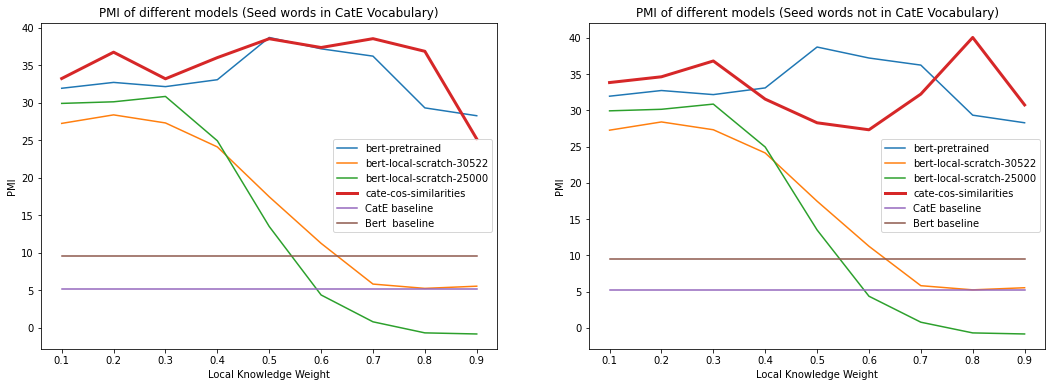

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], pmis_in_vocab[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis_in_vocab[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis_in_vocab[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis_in_vocab[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities', linewidth=3)
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [base_results['cate_cos_similarities']['pmi'] for _ in range(9)],
         label='CatE baseline')

ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [base_results['global_cos_similarities']['pmi'] for _ in range(9)],
         label='Bert  baseline')
ax1.set_xlabel('Local Knowledge Weight')
ax1.set_ylabel('PMI')
ax1.legend()

ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], pmis[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         pmis[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities', linewidth=3)
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [base_results['cate_cos_similarities']['pmi'] for _ in range(9)],
         label='CatE baseline')

ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [base_results['global_cos_similarities']['pmi'] for _ in range(9)],
         label='Bert baseline')
ax2.set_xlabel('Local Knowledge Weight')
ax2.set_ylabel('PMI')
ax2.legend()
ax1.set_title("PMI of different models (Seed words in CatE Vocabulary)")
ax2.set_title("PMI of different models (Seed words not in CatE Vocabulary)")

fig.show()

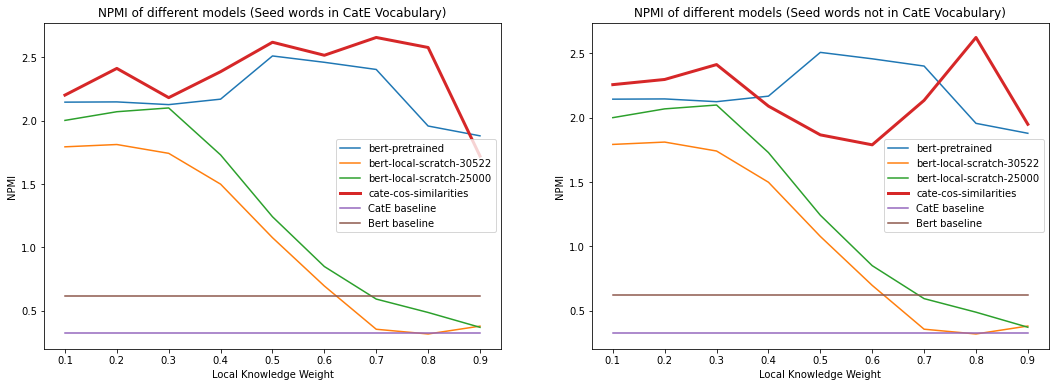

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], npmis_in_vocab[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis_in_vocab[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis_in_vocab[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis_in_vocab[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities', linewidth=3)
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [base_results['cate_cos_similarities']['npmi'] for _ in range(9)],
         label='CatE baseline')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [base_results['global_cos_similarities']['npmi'] for _ in range(9)],
         label='Bert baseline')
ax1.set_xlabel('Local Knowledge Weight')
ax1.set_ylabel('NPMI')
ax1.legend()

ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], npmis[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities', linewidth=3)
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [base_results['cate_cos_similarities']['npmi'] for _ in range(9)],
         label='CatE baseline')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         [base_results['global_cos_similarities']['npmi'] for _ in range(9)],
         label='Bert baseline')
ax2.set_xlabel('Local Knowledge Weight')
ax2.set_ylabel('NPMI')
ax2.legend()
ax1.set_title("NPMI of different models (Seed words in CatE Vocabulary)")
ax2.set_title("NPMI of different models (Seed words not in CatE Vocabulary)")

fig.show()

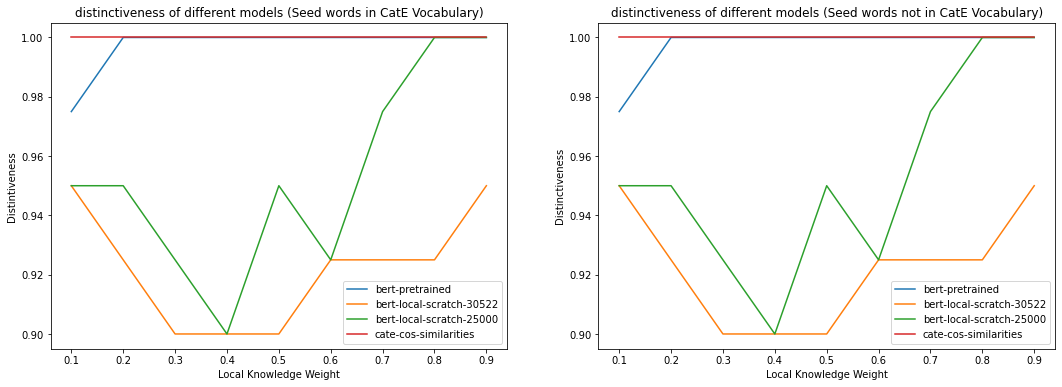

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], dists_in_vocab[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         dists_in_vocab[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         dists_in_vocab[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         dists_in_vocab[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
ax1.set_xlabel('Local Knowledge Weight')
ax1.set_ylabel('Distintiveness')
ax1.legend()

ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], dists[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         dists[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         dists[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         dists[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
ax2.set_xlabel('Local Knowledge Weight')
ax2.set_ylabel('Distinctiveness')
ax2.legend()
ax1.set_title("distinctiveness of different models (Seed words in CatE Vocabulary)")
ax2.set_title("distinctiveness of different models (Seed words not in CatE Vocabulary)")

fig.show()


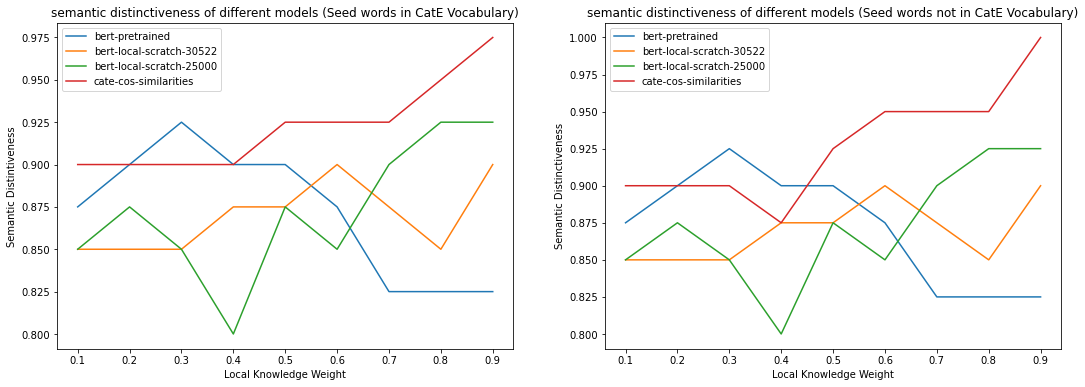

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], sem_dists_in_vocab[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         sem_dists_in_vocab[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         sem_dists_in_vocab[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
ax1.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         sem_dists_in_vocab[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
ax1.set_xlabel('Local Knowledge Weight')
ax1.set_ylabel('Semantic Distintiveness')
ax1.legend()

ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], sem_dists[0]['ensemble_score_bert-pretrained'], label='bert-pretrained')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         sem_dists[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         sem_dists[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
ax2.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         sem_dists[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
ax2.set_xlabel('Local Knowledge Weight')
ax2.set_ylabel('Semantic Distinctiveness')
ax2.legend()
ax1.set_title("semantic distinctiveness of different models (Seed words in CatE Vocabulary)")
ax2.set_title("semantic distinctiveness of different models (Seed words not in CatE Vocabulary)")

fig.show()

In [ ]:

plt.show()

In [ ]:
l = 0.5
g = 0.8
import numpy as np
def ensemble_ranking(score_g, score_l, rho, weight_global, weight_local):
    exponent = 1 / rho
    base = weight_global * np.power(
        1 / score_g, rho) + weight_local * np.power(1 / score_l, rho)
    return 1 / np.power(base, exponent)
for i in range(1, 10):
    print(f"w_g={1-i/10}, w_l={i/10}")
    print(ensemble_ranking(g, l,0.1, 1-i/10, i/10))

ValueError: x and y must have same first dimension, but have shapes (10,) and (9,)

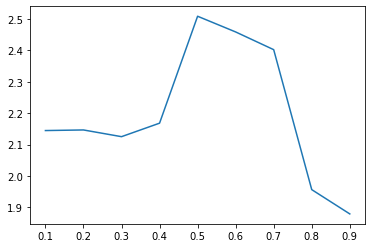

In [20]:
plt.figure()
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis[0]['ensemble_score_bert-pretrained'],
         label='bert-pretrained')
plt.plot([0.1,0,2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
         npmis[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
plt.legend()
plt.show()


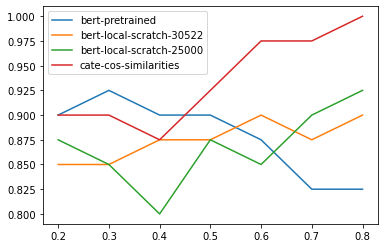

In [12]:
plt.figure()
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         sem_dists[0]['ensemble_score_bert-pretrained'],
         label='bert-pretrained')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         sem_dists[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         sem_dists[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
plt.plot([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
         sem_dists[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
plt.legend()
plt.show()


In [ ]:
plt.figure()
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7],
         dists[0]['ensemble_score_bert-pretrained'],
         label='bert-pretrained')
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7],
         dists[0]['ensemble_score_bert-local-scratch-30522'],
         label='bert-local-scratch-30522')
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7],
         dists[0]['ensemble_score_bert-local-scratch-25000'],
         label='bert-local-scratch-25000')
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7],
         dists[0]['ensemble_score_cate-cos-similarities'],
         label='cate-cos-similarities')
plt.legend()
plt.show()

In [56]:
l = 0.5
g = 0.8
import numpy as np
def ensemble_ranking(score_g, score_l, rho, weight_global, weight_local):
    exponent = 1 / rho
    base = weight_global * np.power(
        1 / score_g, rho) + weight_local * np.power(1 / score_l, rho)
    return 1 / np.power(base, exponent)
for i in range(1, 10):
    print(f"w_g={1-i/10}, w_l={i/10}")
    print(ensemble_ranking(g, l,0.1, 1-i/10, i/10))

w_g=0.9, w_l=0.1
0.7625017139527153
w_g=0.8, w_l=0.2
0.7269277933085015
w_g=0.7, w_l=0.3
0.6931710062212096
w_g=0.6, w_l=0.4
0.6611305640675668
w_g=0.5, w_l=0.5
0.6307117064380795
w_g=0.4, w_l=0.6
0.6018253146364971
w_g=0.30000000000000004, w_l=0.7
0.5743875516084382
w_g=0.19999999999999996, w_l=0.8
0.5483195263802467
w_g=0.09999999999999998, w_l=0.9
0.5235469812365003


In [7]:
import json
with open('./results/evaluations/run-2022-07-07-10-05/local-0.9-global-0.1-rho-0.5.json', 'r') as f:
    res = json.load(f)
sets = res["ensemble_score_cate-cos-similarities"]["word_set"]
import nltk
import pandas as pd

df = pd.read_csv(
    'results/ensemble/local-0.9-global-0.1-rho-0.5/ensemble_score_cate-cos-similarities.csv',
    index_col='_vocab')
from scripts.evaluation import build_word_sets
word_sets = build_word_sets(df, 10)
print(word_sets)
def compute_distinctiveness(word_sets):
    words = list(word_sets.values())
    topics = list(word_sets.keys())
    words = [set(v) for v in words]
    total_items = 0
    unique_words = set()
    words_to_remove = set()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    semantically_unique_words = set()
    for s, _ in zip(words, topics):
        total_items += len(s)
        unique_words = unique_words.union(s)
    distinctiveness = len(unique_words) / total_items
    for word in unique_words:
        for topic in topics:
            if word.startswith(topic) or topic.startswith(word):
                words_to_remove.add(word)
    print(words_to_remove)
    unique_words = (unique_words - words_to_remove).union(topics)
    print(len(unique_words))
    for word in unique_words:
        semantically_unique_words.add(lemmatizer.lemmatize(word))
    print(len(semantically_unique_words))
    sem_dist = (len(semantically_unique_words)) / total_items
    print("====DISTINCTIVENESS====")
    print(f"\t<SUM>: {distinctiveness}")
    print(f"\t<SEMANTICALLY DISTINCT>: {sem_dist}")
    return distinctiveness, sem_dist
compute_distinctiveness(word_sets)

====WORD SET====
	finance:['accounting', 'finance', 'overbooking', 'logistics', 'securities', 'mae', 'mortgage', 'unumprovident', 'expenditures', 'defaulted']
	medicine:['pathology', 'dentistry', 'medicine', 'pharmacy', 'veterinary', 'pediatric', 'medications', 'dental', 'patients', 'therapy']
	sports:['sports', 'basketball', 'baseball', 'lacrosse', 'hockey', 'bruins', 'volleyball', 'football', 'cheerleading', 'sport']
	technology:['technology', 'robotics', 'telecommunication', 'automation', 'alvarion', 'panasonic', 'palmos', 'integrator', 'chinadotcom', 'ims']
{'finance': ['accounting', 'finance', 'overbooking', 'logistics', 'securities', 'mae', 'mortgage', 'unumprovident', 'expenditures', 'defaulted'], 'medicine': ['pathology', 'dentistry', 'medicine', 'pharmacy', 'veterinary', 'pediatric', 'medications', 'dental', 'patients', 'therapy'], 'sports': ['sports', 'basketball', 'baseball', 'lacrosse', 'hockey', 'bruins', 'volleyball', 'football', 'cheerleading', 'sport'], 'technology': ['

(1.0, 0.975)

# Cooccurrence Matrix

In [13]:
import pandas as pd
import numpy as np
vocab = ["cat", "sit", "mat", "other", "run"]
corpus = ["cat sit mat run", "other cat run sit"]
df = pd.DataFrame(index=vocab, columns=vocab, data=np.zeros((len(vocab), len(vocab)), dtype=np.uint32))
for line in corpus:
    words = line.split()
    for i, word in enumerate(words):
        df.loc[word, words] += 1
for i in range(len(vocab)):
    df.iloc[i, i] = 0

df.head()

,cat,sit,mat,other,run
cat,0,2,1,1,2
sit,2,0,1,1,2
mat,1,1,0,0,1
other,1,1,0,0,1
run,2,2,1,1,0


In [ ]:
from torch.utils.data import Dataset

class AgnewsDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
       

In [2]:
from transformers import BertModel, BertTokenizer, BertForPreTraining, BertForMaskedLM, BertConfig
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from scripts.utils.embeddings import cosine_similarity_with_topic
cosine_similarity_with_topic("finance", ["finance", "bank"], tokenizer, model)

Output()

Output()

array([0.99999994, 0.6249588 ], dtype=float32)

In [13]:
res = model(**tokens)
res.last_hidden_state.shape

torch.Size([2, 4, 768])

In [7]:
from transformers import BertModel, BertTokenizer, BertForPreTraining, BertForMaskedLM, BertConfig
def load_model(path):
    model = BertModel.from_pretrained('bert-base-uncased')
    model.load_state_dict(
        torch.load(path), strict=False)
    return model

load_model('models/agnews/bert-finetuned/epoch=49-step=42550.ckpt')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: Error(s) in loading state_dict for BertModel:
	Missing key(s) in state_dict: "embeddings.position_ids", "embeddings.word_embeddings.weight", "embeddings.position_embeddings.weight", "embeddings.token_type_embeddings.weight", "embeddings.LayerNorm.weight", "embeddings.LayerNorm.bias", "encoder.layer.0.attention.self.query.weight", "encoder.layer.0.attention.self.query.bias", "encoder.layer.0.attention.self.key.weight", "encoder.layer.0.attention.self.key.bias", "encoder.layer.0.attention.self.value.weight", "encoder.layer.0.attention.self.value.bias", "encoder.layer.0.attention.output.dense.weight", "encoder.layer.0.attention.output.dense.bias", "encoder.layer.0.attention.output.LayerNorm.weight", "encoder.layer.0.attention.output.LayerNorm.bias", "encoder.layer.0.intermediate.dense.weight", "encoder.layer.0.intermediate.dense.bias", "encoder.layer.0.output.dense.weight", "encoder.layer.0.output.dense.bias", "encoder.layer.0.output.LayerNorm.weight", "encoder.layer.0.output.LayerNorm.bias", "encoder.layer.1.attention.self.query.weight", "encoder.layer.1.attention.self.query.bias", "encoder.layer.1.attention.self.key.weight", "encoder.layer.1.attention.self.key.bias", "encoder.layer.1.attention.self.value.weight", "encoder.layer.1.attention.self.value.bias", "encoder.layer.1.attention.output.dense.weight", "encoder.layer.1.attention.output.dense.bias", "encoder.layer.1.attention.output.LayerNorm.weight", "encoder.layer.1.attention.output.LayerNorm.bias", "encoder.layer.1.intermediate.dense.weight", "encoder.layer.1.intermediate.dense.bias", "encoder.layer.1.output.dense.weight", "encoder.layer.1.output.dense.bias", "encoder.layer.1.output.LayerNorm.weight", "encoder.layer.1.output.LayerNorm.bias", "encoder.layer.2.attention.self.query.weight", "encoder.layer.2.attention.self.query.bias", "encoder.layer.2.attention.self.key.weight", "encoder.layer.2.attention.self.key.bias", "encoder.layer.2.attention.self.value.weight", "encoder.layer.2.attention.self.value.bias", "encoder.layer.2.attention.output.dense.weight", "encoder.layer.2.attention.output.dense.bias", "encoder.layer.2.attention.output.LayerNorm.weight", "encoder.layer.2.attention.output.LayerNorm.bias", "encoder.layer.2.intermediate.dense.weight", "encoder.layer.2.intermediate.dense.bias", "encoder.layer.2.output.dense.weight", "encoder.layer.2.output.dense.bias", "encoder.layer.2.output.LayerNorm.weight", "encoder.layer.2.output.LayerNorm.bias", "encoder.layer.3.attention.self.query.weight", "encoder.layer.3.attention.self.query.bias", "encoder.layer.3.attention.self.key.weight", "encoder.layer.3.attention.self.key.bias", "encoder.layer.3.attention.self.value.weight", "encoder.layer.3.attention.self.value.bias", "encoder.layer.3.attention.output.dense.weight", "encoder.layer.3.attention.output.dense.bias", "encoder.layer.3.attention.output.LayerNorm.weight", "encoder.layer.3.attention.output.LayerNorm.bias", "encoder.layer.3.intermediate.dense.weight", "encoder.layer.3.intermediate.dense.bias", "encoder.layer.3.output.dense.weight", "encoder.layer.3.output.dense.bias", "encoder.layer.3.output.LayerNorm.weight", "encoder.layer.3.output.LayerNorm.bias", "encoder.layer.4.attention.self.query.weight", "encoder.layer.4.attention.self.query.bias", "encoder.layer.4.attention.self.key.weight", "encoder.layer.4.attention.self.key.bias", "encoder.layer.4.attention.self.value.weight", "encoder.layer.4.attention.self.value.bias", "encoder.layer.4.attention.output.dense.weight", "encoder.layer.4.attention.output.dense.bias", "encoder.layer.4.attention.output.LayerNorm.weight", "encoder.layer.4.attention.output.LayerNorm.bias", "encoder.layer.4.intermediate.dense.weight", "encoder.layer.4.intermediate.dense.bias", "encoder.layer.4.output.dense.weight", "encoder.layer.4.output.dense.bias", "encoder.layer.4.output.LayerNorm.weight", "encoder.layer.4.output.LayerNorm.bias", "encoder.layer.5.attention.self.query.weight", "encoder.layer.5.attention.self.query.bias", "encoder.layer.5.attention.self.key.weight", "encoder.layer.5.attention.self.key.bias", "encoder.layer.5.attention.self.value.weight", "encoder.layer.5.attention.self.value.bias", "encoder.layer.5.attention.output.dense.weight", "encoder.layer.5.attention.output.dense.bias", "encoder.layer.5.attention.output.LayerNorm.weight", "encoder.layer.5.attention.output.LayerNorm.bias", "encoder.layer.5.intermediate.dense.weight", "encoder.layer.5.intermediate.dense.bias", "encoder.layer.5.output.dense.weight", "encoder.layer.5.output.dense.bias", "encoder.layer.5.output.LayerNorm.weight", "encoder.layer.5.output.LayerNorm.bias", "encoder.layer.6.attention.self.query.weight", "encoder.layer.6.attention.self.query.bias", "encoder.layer.6.attention.self.key.weight", "encoder.layer.6.attention.self.key.bias", "encoder.layer.6.attention.self.value.weight", "encoder.layer.6.attention.self.value.bias", "encoder.layer.6.attention.output.dense.weight", "encoder.layer.6.attention.output.dense.bias", "encoder.layer.6.attention.output.LayerNorm.weight", "encoder.layer.6.attention.output.LayerNorm.bias", "encoder.layer.6.intermediate.dense.weight", "encoder.layer.6.intermediate.dense.bias", "encoder.layer.6.output.dense.weight", "encoder.layer.6.output.dense.bias", "encoder.layer.6.output.LayerNorm.weight", "encoder.layer.6.output.LayerNorm.bias", "encoder.layer.7.attention.self.query.weight", "encoder.layer.7.attention.self.query.bias", "encoder.layer.7.attention.self.key.weight", "encoder.layer.7.attention.self.key.bias", "encoder.layer.7.attention.self.value.weight", "encoder.layer.7.attention.self.value.bias", "encoder.layer.7.attention.output.dense.weight", "encoder.layer.7.attention.output.dense.bias", "encoder.layer.7.attention.output.LayerNorm.weight", "encoder.layer.7.attention.output.LayerNorm.bias", "encoder.layer.7.intermediate.dense.weight", "encoder.layer.7.intermediate.dense.bias", "encoder.layer.7.output.dense.weight", "encoder.layer.7.output.dense.bias", "encoder.layer.7.output.LayerNorm.weight", "encoder.layer.7.output.LayerNorm.bias", "encoder.layer.8.attention.self.query.weight", "encoder.layer.8.attention.self.query.bias", "encoder.layer.8.attention.self.key.weight", "encoder.layer.8.attention.self.key.bias", "encoder.layer.8.attention.self.value.weight", "encoder.layer.8.attention.self.value.bias", "encoder.layer.8.attention.output.dense.weight", "encoder.layer.8.attention.output.dense.bias", "encoder.layer.8.attention.output.LayerNorm.weight", "encoder.layer.8.attention.output.LayerNorm.bias", "encoder.layer.8.intermediate.dense.weight", "encoder.layer.8.intermediate.dense.bias", "encoder.layer.8.output.dense.weight", "encoder.layer.8.output.dense.bias", "encoder.layer.8.output.LayerNorm.weight", "encoder.layer.8.output.LayerNorm.bias", "encoder.layer.9.attention.self.query.weight", "encoder.layer.9.attention.self.query.bias", "encoder.layer.9.attention.self.key.weight", "encoder.layer.9.attention.self.key.bias", "encoder.layer.9.attention.self.value.weight", "encoder.layer.9.attention.self.value.bias", "encoder.layer.9.attention.output.dense.weight", "encoder.layer.9.attention.output.dense.bias", "encoder.layer.9.attention.output.LayerNorm.weight", "encoder.layer.9.attention.output.LayerNorm.bias", "encoder.layer.9.intermediate.dense.weight", "encoder.layer.9.intermediate.dense.bias", "encoder.layer.9.output.dense.weight", "encoder.layer.9.output.dense.bias", "encoder.layer.9.output.LayerNorm.weight", "encoder.layer.9.output.LayerNorm.bias", "encoder.layer.10.attention.self.query.weight", "encoder.layer.10.attention.self.query.bias", "encoder.layer.10.attention.self.key.weight", "encoder.layer.10.attention.self.key.bias", "encoder.layer.10.attention.self.value.weight", "encoder.layer.10.attention.self.value.bias", "encoder.layer.10.attention.output.dense.weight", "encoder.layer.10.attention.output.dense.bias", "encoder.layer.10.attention.output.LayerNorm.weight", "encoder.layer.10.attention.output.LayerNorm.bias", "encoder.layer.10.intermediate.dense.weight", "encoder.layer.10.intermediate.dense.bias", "encoder.layer.10.output.dense.weight", "encoder.layer.10.output.dense.bias", "encoder.layer.10.output.LayerNorm.weight", "encoder.layer.10.output.LayerNorm.bias", "encoder.layer.11.attention.self.query.weight", "encoder.layer.11.attention.self.query.bias", "encoder.layer.11.attention.self.key.weight", "encoder.layer.11.attention.self.key.bias", "encoder.layer.11.attention.self.value.weight", "encoder.layer.11.attention.self.value.bias", "encoder.layer.11.attention.output.dense.weight", "encoder.layer.11.attention.output.dense.bias", "encoder.layer.11.attention.output.LayerNorm.weight", "encoder.layer.11.attention.output.LayerNorm.bias", "encoder.layer.11.intermediate.dense.weight", "encoder.layer.11.intermediate.dense.bias", "encoder.layer.11.output.dense.weight", "encoder.layer.11.output.dense.bias", "encoder.layer.11.output.LayerNorm.weight", "encoder.layer.11.output.LayerNorm.bias", "pooler.dense.weight", "pooler.dense.bias". 
	Unexpected key(s) in state_dict: "epoch", "global_step", "pytorch-lightning_version", "state_dict", "loops", "callbacks", "optimizer_states", "lr_schedulers". 

In [15]:
import logging
from rich.progress import track
import pandas  as pd
def build_cooccurance_matrix(
    lines,
    vocabulary,
):
    logging.info("Starting building co-occurrence matrix")
    coocurrence_matrix = pd.DataFrame(index=vocabulary, columns=vocabulary)
    coocurrence_matrix.fillna(0, inplace=True)
    for line in track(lines, description="Building co-occurrence matrix"):
        words = line.split(' ')
        words = [w for w in words if w in vocabulary]

        for word in words:
            sentence_words = set(words)
            sentence_words.discard(word)
            sentence_words = list(sentence_words)
            coocurrence_matrix.loc[word, sentence_words] += 1

    for i in range(len(vocabulary)):
        coocurrence_matrix.iloc[i, i] = 0
    return coocurrence_matrix
vocab = ['cat', 'sit', 'run', 'mat']
lines = ['cat is sit on mat mat', 'cat is run on mat']
build_cooccurance_matrix(lines, vocab)

Output()

,cat,sit,run,mat
cat,0,1,1,2
sit,1,0,0,1
run,1,0,0,1
mat,3,2,1,0


In [16]:
import spacy

nlp = spacy.load("en_core_web_trf")

# for doc in nlp.pipe(["sampling anterior apical region result"]):
#     # Do something with the doc here
#     print([word.lemma_ for word in doc])
token = nlp("behavioural")
for doc in token:
    print(doc.l
)

5747727994164715725
